# Main ERP Pipeline

This notebook contains processing steps for BCI III P300 dataset.
The goal is to classify ERP forms for target and common stimuli using peak features

In [136]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [137]:
import sys
sys.path.append("../src")

In [138]:
from load import load_bci_iii_data as load_data

In [139]:
from preprocess import process_signal, restore_raw, get_events

In [140]:
import pandas as pd

In [141]:
import matplotlib.pyplot as plt

# Load and preprocess data

You can find the description of each method in the related src/*.py file

In [142]:
good_subject = "Subject_A_Train"

In [49]:
sessions_df, characters = load_data(good_subject)

In [50]:
sessions_df['Trigger'].value_counts()

2.0    306000
0.0    295290
1.0     61200
Name: Trigger, dtype: int64

Creating RawArray with float64 data, n_channels=65, n_times=662490
    Range : 0 ... 662489 =      0.000 ...  2760.371 secs
Ready.
The unit for channel(s) Af3, Af4, Af7, Af8, Afz, C1, C2, C3, C4, C5, C6, Cp1, Cp2, Cp3, Cp4, Cp5, Cp6, Cpz, Cz, F1, F2, F3, F4, F5, F6, F7, F8, Fc1, Fc2, Fc3, Fc4, Fc5, Fc6, Fcz, Fp1, Fp2, Fpz, Ft7, Ft8, Fz, Iz, O1, O2, Oz, P1, P2, P3, P4, P5, P6, P7, P8, Po3, Po4, Po7, Po8, Poz, Pz, T10, T7, T8, T9, Tp7, Tp8 has changed from NA to V.
15300 events found
Event IDs: [1 2]


../src/preprocess.py:24: RuntimeWarning: The unit for channel(s) Af3, Af4, Af7, Af8, Afz, C1, C2, C3, C4, C5, C6, Cp1, Cp2, Cp3, Cp4, Cp5, Cp6, Cpz, Cz, F1, F2, F3, F4, F5, F6, F7, F8, Fc1, Fc2, Fc3, Fc4, Fc5, Fc6, Fcz, Fp1, Fp2, Fpz, Ft7, Ft8, Fz, Iz, O1, O2, Oz, P1, P2, P3, P4, P5, P6, P7, P8, Po3, Po4, Po7, Po8, Poz, Pz, T10, T7, T8, T9, Tp7, Tp8 has changed from NA to V.
  raw.set_channel_types(channel_types)


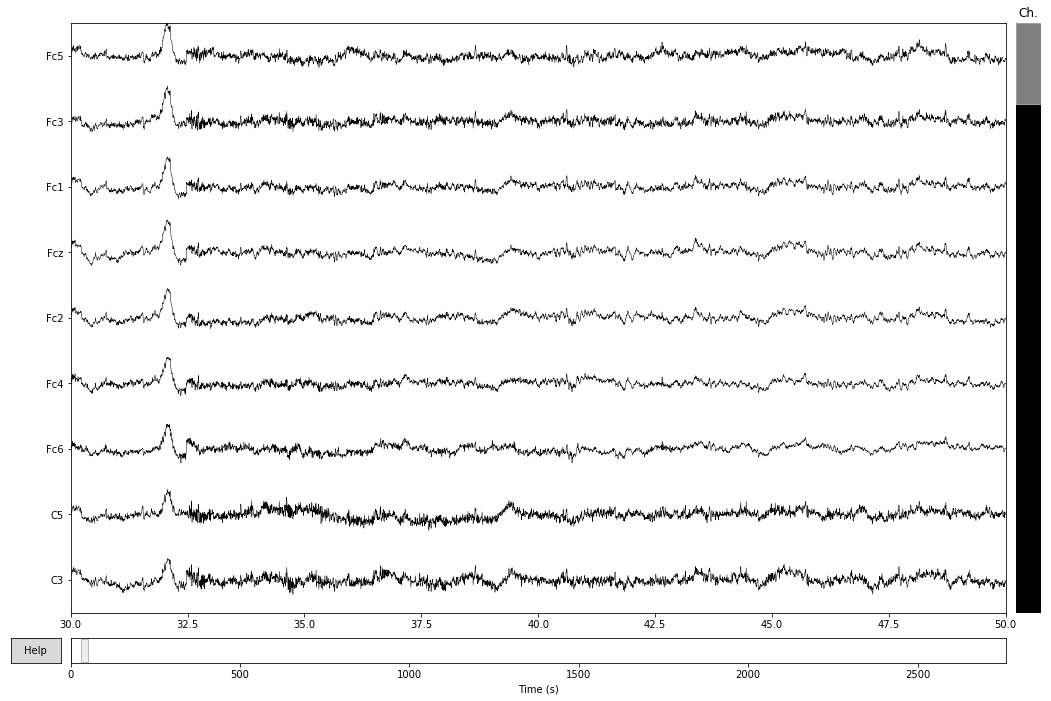

Setting up band-stop filter from 49 - 51 Hz
Filter length of 1585 samples (6.604 sec) selected
Setting up band-pass filter from 0.5 - 30 Hz
l_trans_bandwidth chosen to be 0.5 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1585 samples (6.604 sec) selected


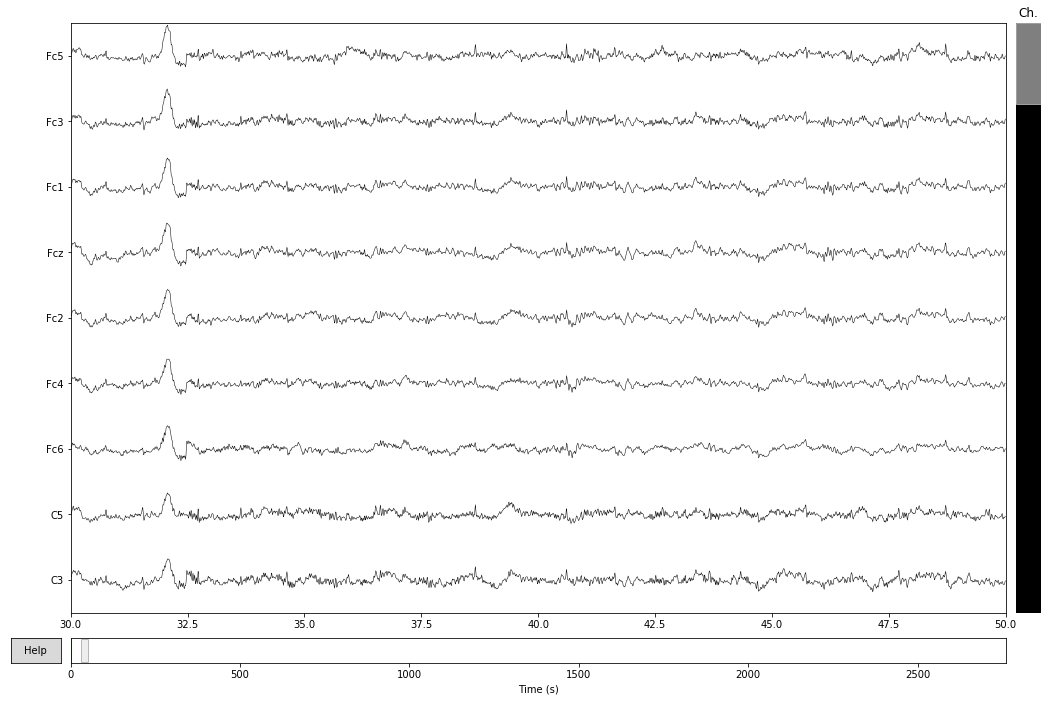

5956 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 5956 events and 193 original time points ...
0 bad epochs dropped
time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


../src/visualize.py:31: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  epochs['1'].average().plot(units=units)


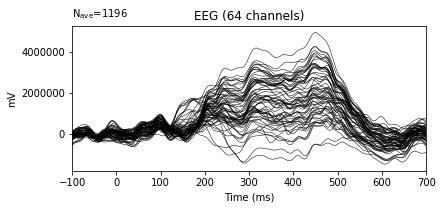

time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


../src/visualize.py:34: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  epochs['2'].average().plot(units=units)


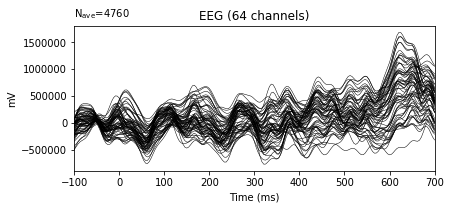

In [65]:
epochs = process_signal(sessions_df)

In [66]:
epochs

<Epochs  |   5956 events (all good), -0.1 - 0.7 sec, baseline [None, 0], ~561.4 MB, data loaded,
 '1': 1196
 '2': 4760>

# Train model

In [67]:
from models import P300ClassifierLDA

# Find TOP-8 channels by importance

# Add train test dataset

In [132]:
from tqdm import tqdm_notebook

In [147]:
import mne

In [158]:
supported_channels = [
    "Fp1", "Fpz", "Fp2",
    "Af3", "Afz", "Af4",
    "F7", "F3", "Fz", "F4", "F8",
    "Fc5", "Fc1", "Fc2", "Fc6",
    "T3", "C3", "Cz", "C4", "T4",
    "Cp5", "Cp1", "Cp2", "Cp6",
    "T5", "P3", "Pz", "P4", "T6",
    "Po3", "Poz", "Po4",
    "O1", "Oz", "O2"
]

In [160]:
supported_channels = [c for c in supported_channels if c in epochs.ch_names]

In [161]:
with mne.utils.use_log_level('error'):
    selected_epochs = epochs.pick_channels(supported_channels).copy()
    train_size = int(epochs.events.shape[0] * 0.7)
    selected_channels = []

    for i in range(0, 8):
        max_score = 1
        max_channel = None

        for channel in tqdm_notebook(selected_epochs.ch_names):
            picked_channels = [c for c in selected_epochs.ch_names if c not in (selected_channels + [channel])]
            train_epochs = selected_epochs[:train_size].copy().pick_channels(picked_channels)
            test_epochs = selected_epochs[:train_size].copy().pick_channels(picked_channels)

            model = P300ClassifierLDA()
            model.fit(train_epochs)

            y_pred, y_true = model.predict(test_epochs)
            score = roc_auc_score(y_true, y_pred)

            if score < max_score:
                max_score = score
                max_channel = channel

        print(max_score, max_channel)
        selected_channels += [max_channel]

0.8606606118995299 Pz


0.8531022562847979 Poz


0.8453338962318276 Cp2


0.8385141644746099 Cz


0.8308381775078753 Cp1


0.8231730155121835 Fc1


0.8133901283480733 Fz


0.805340679880348 Fc2


In [163]:
selected_channels

['Pz', 'Poz', 'Cp2', 'Cz', 'Cp1', 'Fc1', 'Fz', 'Fc2']

In [174]:
train_epochs = epochs[:train_size].copy().pick_channels(selected_channels)
test_epochs = epochs[:train_size].copy().pick_channels(selected_channels)

model = P300ClassifierLDA()
model.fit(train_epochs)

y_pred, y_true = model.predict(test_epochs)
score = roc_auc_score(y_true, y_pred)
score

The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20 Hz, which can cause aliasing artifacts.
The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20 Hz, which can cause aliasing artifacts.


../src/models.py:17: RuntimeWarning: The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20 Hz, which can cause aliasing artifacts.
  epochs = epochs.decimate(12)
../src/models.py:17: RuntimeWarning: The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20 Hz, which can cause aliasing artifacts.
  epochs = epochs.decimate(12)


0.7481011196628382

In [175]:
! mkdir ../test-model

mkdir: невозможно создать каталог «../test-model»: Файл существует


In [176]:
model.save("../test-model")

In [ ]:
selected_channels

In [110]:
model.fit(epochs)

The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20 Hz, which can cause aliasing artifacts.


../src/models.py:17: RuntimeWarning: The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20 Hz, which can cause aliasing artifacts.
  epochs = epochs.decimate(12)


In [118]:
import eli5

In [111]:
y_pred, y_true = model.predict(epochs)

The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20 Hz, which can cause aliasing artifacts.


../src/models.py:17: RuntimeWarning: The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20 Hz, which can cause aliasing artifacts.
  epochs = epochs.decimate(12)


In [112]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [115]:
confusion_matrix(y_true, y_pred > 0.5)

array([[4561,  199],
       [ 434,  762]])

# Experimental section

In [ ]:
model.save("")

In [ ]:
i = 1
session_df = sessions_df[sessions_df["InputIndex"] == i]
character = characters[0][i]

In [10]:
len(characters[0])

85

In [11]:
sessions_df.shape

(662490, 67)

In [12]:
from preprocess import *

In [13]:
raw = restore_raw(session_df)

Creating RawArray with float64 data, n_channels=65, n_times=7794
    Range : 0 ... 7793 =      0.000 ...    32.471 secs
Ready.
The unit for channel(s) Af3, Af4, Af7, Af8, Afz, C1, C2, C3, C4, C5, C6, Cp1, Cp2, Cp3, Cp4, Cp5, Cp6, Cpz, Cz, F1, F2, F3, F4, F5, F6, F7, F8, Fc1, Fc2, Fc3, Fc4, Fc5, Fc6, Fcz, Fp1, Fp2, Fpz, Ft7, Ft8, Fz, Iz, O1, O2, Oz, P1, P2, P3, P4, P5, P6, P7, P8, Po3, Po4, Po7, Po8, Poz, Pz, T10, T7, T8, T9, Tp7, Tp8 has changed from NA to V.


../src/preprocess.py:24: RuntimeWarning: The unit for channel(s) Af3, Af4, Af7, Af8, Afz, C1, C2, C3, C4, C5, C6, Cp1, Cp2, Cp3, Cp4, Cp5, Cp6, Cpz, Cz, F1, F2, F3, F4, F5, F6, F7, F8, Fc1, Fc2, Fc3, Fc4, Fc5, Fc6, Fcz, Fp1, Fp2, Fpz, Ft7, Ft8, Fz, Iz, O1, O2, Oz, P1, P2, P3, P4, P5, P6, P7, P8, Po3, Po4, Po7, Po8, Poz, Pz, T10, T7, T8, T9, Tp7, Tp8 has changed from NA to V.
  raw.set_channel_types(channel_types)


In [14]:
events = get_events(raw)

180 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12]


In [15]:
filter_signal(raw)

Setting up band-stop filter from 49 - 51 Hz
Filter length of 1585 samples (6.604 sec) selected
Setting up band-pass filter from 0.5 - 30 Hz
l_trans_bandwidth chosen to be 0.5 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1585 samples (6.604 sec) selected


In [16]:
raw = scale_signal(raw, events, session_df)

Creating RawArray with float64 data, n_channels=65, n_times=7794
    Range : 0 ... 7793 =      0.000 ...    32.471 secs
Ready.
The unit for channel(s) Af3, Af4, Af7, Af8, Afz, C1, C2, C3, C4, C5, C6, Cp1, Cp2, Cp3, Cp4, Cp5, Cp6, Cpz, Cz, F1, F2, F3, F4, F5, F6, F7, F8, Fc1, Fc2, Fc3, Fc4, Fc5, Fc6, Fcz, Fp1, Fp2, Fpz, Ft7, Ft8, Fz, Iz, O1, O2, Oz, P1, P2, P3, P4, P5, P6, P7, P8, Po3, Po4, Po7, Po8, Poz, Pz, T10, T7, T8, T9, Tp7, Tp8 has changed from NA to V.


../src/preprocess.py:24: RuntimeWarning: The unit for channel(s) Af3, Af4, Af7, Af8, Afz, C1, C2, C3, C4, C5, C6, Cp1, Cp2, Cp3, Cp4, Cp5, Cp6, Cpz, Cz, F1, F2, F3, F4, F5, F6, F7, F8, Fc1, Fc2, Fc3, Fc4, Fc5, Fc6, Fcz, Fp1, Fp2, Fpz, Ft7, Ft8, Fz, Iz, O1, O2, Oz, P1, P2, P3, P4, P5, P6, P7, P8, Po3, Po4, Po7, Po8, Poz, Pz, T10, T7, T8, T9, Tp7, Tp8 has changed from NA to V.
  raw.set_channel_types(channel_types)


In [17]:
cleaned_events = reject_bad_events(raw, events)

In [18]:
epochs = get_epochs(raw, events)

106 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 106 events and 193 original time points ...
1 bad epochs dropped


In [19]:
epochs

<Epochs  |   105 events (all good), -0.1 - 0.7 sec, baseline [None, 0], ~10.0 MB, data loaded,
 '1': 15
 '10': 9
 '11': 7
 '12': 9
 '2': 6
 '3': 8
 '4': 8
 '5': 9
 '6': 8
 '7': 6
 '8': 11
 '9': 9>

# Experimental section

Perform an averaging of the signal for each character to find P300 manually

In [957]:
chars = [chr(ord('A') + i) for i in range(0, 26)] + [str(i) for i in range(1, 10)] + ["_"]

char_events = {
    chars[i]: [str(i % 6 + 1), str(i // 6 + 7)]
    for i in range(0, 36)
}

G
time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-958-65788a1a5e13>:5: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  epochs[events].average().plot()


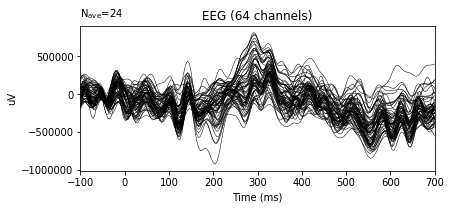

In [958]:
for char in chars:
    events = char_events[char]
    if char == character:
        print(char)
        epochs[events].average().plot()
    plt.show()

Get FFT decomposition of the signal for the certain character

In [877]:
events = char_events['G']

In [853]:
signal = epochs[events].average().data

In [854]:
signal_fft = np.abs(np.fft.fft(signal, axis=1))

In [855]:
signal_fft[:, :signal_fft.shape[-1] // 2].shape

(64, 96)

In [856]:
import seaborn as sns

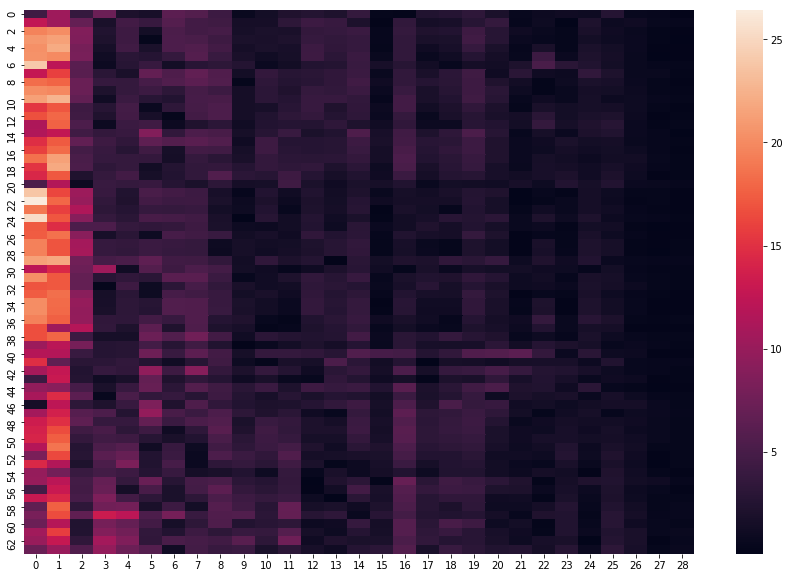

In [857]:
sns.heatmap(signal_fft[:, 1:30])

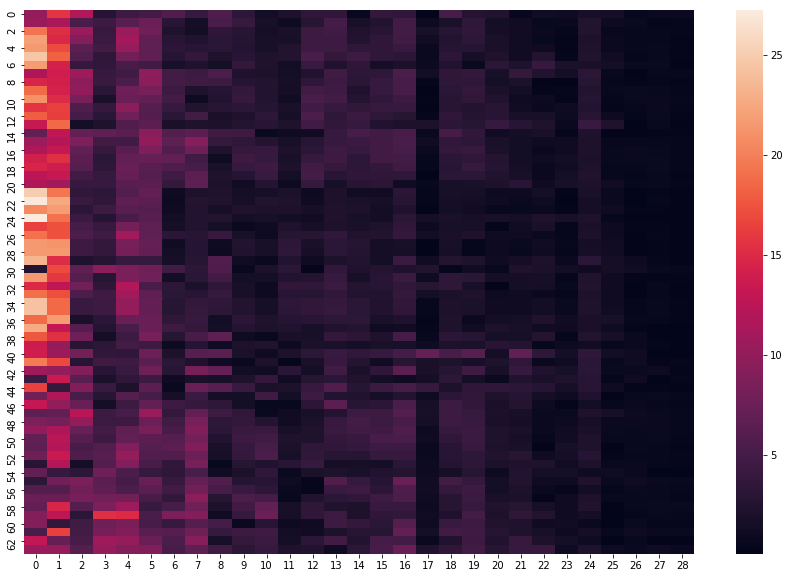

In [851]:
sns.heatmap(signal_fft[:, 1:30])

In [795]:
signal.shape

(64, 193)

In [786]:
events = char_events[character] 
extract_features('s1', epochs[events], sliding_window_size=12)

Averaging by 24 attemps


[[396.875, 0.1901147757265359, 0.20684920720003508, 12.5, 12.5, 0, 's1'],
 [418.75, 0.2331221548863106, 0.5227947693939884, 12.5, 34.375, 1, 's1'],
 [396.875, 0.31329240919167134, 0.18193203040750408, 34.375, 12.5, 2, 's1'],
 [396.875, 0.6740905846789128, 0.1263286107652129, 96.875, 12.5, 3, 's1'],
 [396.875, 0.7611099966475248, 0.18677775718439238, 96.875, 12.5, 4, 's1'],
 [393.75, 0.4658931455482949, 0.20784941044862598, 43.75, 15.625, 5, 's1'],
 [390.625, 0.253728230178136, 0.22982031853692125, 15.625, 15.625, 6, 's1'],
 [418.75, 0.2769373707628518, 0.3576898078776644, 12.5, 15.625, 7, 's1'],
 [418.75, 0.18431649394526717, 0.4413901781792146, 12.5, 37.5, 8, 's1'],
 [418.75, 0.13771216693948843, 0.44865661229602105, 12.5, 37.5, 9, 's1'],
 [418.75, 0.13367607003713164, 0.5059916157985636, 12.5, 37.5, 10, 's1'],
 [418.75, 0.15488115909125988, 0.5446359234981913, 12.5, 34.375, 11, 's1'],
 [393.75, 0.22985220712882184, 0.2072605813864882, 15.625, 12.5, 12, 's1'],
 [393.75, 0.203985239513

In [787]:
char = 'M'
events = char_events[char] 
extract_features('s1', epochs[events], sliding_window_size=12)

Averaging by 22 attemps


[[200.0, 0.35952809653946344, 0.44871691317814744, 18.75, 31.25, 0, 's1'],
 [415.625, 0.22152170492951126, 0.47756336888634965, 53.125, 40.625, 1, 's1'],
 [421.875, 0.14066251835076768, 0.6123264474540089, 12.5, 37.5, 2, 's1'],
 [421.875, 0.13187804081147853, 0.6302738674843023, 15.625, 37.5, 3, 's1'],
 [421.875, 0.15876770039166993, 0.6522736924461163, 15.625, 37.5, 4, 's1'],
 [421.875, 0.21397656127168863, 0.5993915541504028, 12.5, 37.5, 5, 's1'],
 [393.75, 0.48771171361031007, 0.32429886956389137, 37.5, 12.5, 6, 's1'],
 [200.0, 0.49234635889075196, 0.4880541757133985, 15.625, 25.0, 7, 's1'],
 [396.875, 0.2261863708704608, 0.11008441040843936, 21.875, 12.5, 8, 's1'],
 [421.875, 0.11668055225976748, 0.49891857364001, 12.5, 34.375, 9, 's1'],
 [421.875, 0.16505570327409627, 0.6109870664040863, 15.625, 37.5, 10, 's1'],
 [421.875, 0.19843257235412934, 0.5659346941331733, 15.625, 37.5, 11, 's1'],
 [421.875, 0.27254816233157303, 0.5383395336300708, 12.5, 37.5, 12, 's1'],
 [393.75, 0.4833907

In [334]:
from peaks import extract_features